# Main code

## Libraries and Modules

In [1]:
import csv
import glob
import os
import time

import numpy as np
from scipy.spatial import Voronoi
import cv2

import import_ipynb
import machines
import tas #Threat Assessment Strategy: Voronoi
import pps #Path Planning Strategy: AGA and RHC
import pts #Path Tracking Strategy: Deadlock
import vertices_assembler as assembler
import utils

importing Jupyter notebook from machines.ipynb
importing Jupyter notebook from tas.ipynb
importing Jupyter notebook from node_linker.ipynb
importing Jupyter notebook from pps.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from pts.ipynb
importing Jupyter notebook from vertices_assembler.ipynb


## Global Parameters

In [23]:
parameters = {"deadlock_mov": 0.1,
              "movement"    : 0.1,
              "previous"    : 1,
              "radius"      : 0.1,
              "robots"      : 5,
              "tolerance"   : 0.05
             }

## General Options

* **algorithm:** "aga" or "rhc".

* **breakpoint:** Number of step to inspect code (data and images). A high
number blocks the change of the verbose and plot state.

* **experiments:** Number of experiments for each parameter.

* **optimize:** Enable RHC.

* **palette:** Color for each robot.

* **path_data:** Path string.

* **path_image:** Path string.

* **plot:** Generate images.

* **save_data:** Only valuable data for analysis.

* **save_image:** In the machine.

* **see_more_steps:** From breakpoint.

* **seed:** For the generation of pseudo random number.

* **verbose:** Show running data.

* **zoom:** For image dimensions.

In [19]:
opt = { "algorithm"  : "aga",
        "breakpoint" : 10000,
        "experiments": 1,
        "optimize"   : 0,
        "path_data"  : "/home/leduin/Escritorio/Tesis/Resultados/Datos/",
        "path_image" : "/home/leduin/Escritorio/Tesis/Imagenes/",
        "plot"       : 1,
        "save_image" : 1,
        "save_data"  : 0,
        "see_more_steps" : 0,
        "seed"       : 0,
        "verbose"    : 0,
        "zoom"       : 0,
       }

## Main Loop
`def main_module(key)`

### Parameters:
* **key : string**
    * Name of the parameter
* **T&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: int**
    * Number of receding horizon steps

In [4]:
def main_module(key, T):
    with open(opt["path_data"]+opt["algorithm"]+"/"+key+".csv","a") as f:
        if opt["save_data"]:
            csv_writer = csv.writer(f)
        for experiment in range(opt["experiments"]):
            #--------------------------INITIALIZATION--------------------------
            start_time = time.time()
            inst_experiment = experiment + opt["seed"]
            robots = [machines.Robot(i) for i in range(parameters["robots"])]
            # Generate positions, distances, Voronoi attibutes and colors
            utils.pos_gen(parameters["robots"], robots, inst_experiment)
            pos_i = np.array([agent.pos_i for agent in robots])
            pos_f = np.array([agent.pos_f for agent in robots])
            vor_i = Voronoi(pos_i)
            vor_f = Voronoi(pos_f)
            utils.colors(parameters["robots"], robots)
            finished = np.all(pos_i == pos_f) 
            step = 0
            #-------------------COLLISION FREE CONFIGURATION-------------------
            configuration = utils.collision(vor_i.ridge_points,
                                            parameters["radius"], robots)
            if configuration["crash"]:
                print(configuration["message"])
                break
            #-----------------------------MAIN LOOP----------------------------
            while not finished:
                pos_i = np.array([agent.pos_i for agent in robots])
                #Final iteration
                if np.all(pos_i == pos_f):
                    finished = True
                # Generate Voronoi attributes for the current positions
                vor_i = Voronoi(pos_i)
                utils.neighborhood(robots, vor_i.ridge_points)
                if opt["verbose"]:
                    print("==================================================")
                    print('                    MAIN DATA')
                    print("==================================================")
                    print('\nID\tCurrent Pos\tFinal Pos\tColors\tNeighboors')
                    for agent in robots:
                        print('%i\t[%.2F,\t%.2F]\t[%.2F,\t%.2F]\t%s\t'
                              % (agent.id, agent.pos_i[0], agent.pos_i[1],
                                 agent.pos_f[0], agent.pos_f[1], agent.color),
                              agent.neighbors_id)
                for agent in robots:
                    agent.path.append(agent.pos_i)
                # Get the approximated values of inf vertices
                vor_prox = tas.vor_prox(pos_i, opt["verbose"], vor_i)
                # Assemble the vertices and get the ordered vertices
                assembler.main(opt["verbose"], robots, vor_i, vor_prox["edge"])
                # TAS: Generate the BVC
                tas.bvc_gen(parameters["radius"], robots, opt["verbose"],
                            vor_prox)
                # PPS: Get the closer points
                pps.controller(opt, parameters["radius"], robots, step, T)
                # Plotting
                if opt["plot"]:
                    utils.plot(opt, robots, vor_prox)
                utils.save_image(parameters["robots"], opt, step)
                # PTS: Deadlock testing and solutions
                pts.deadlock_test(opt, parameters, robots, step)
                if opt["verbose"] or opt["plot"]:
                    print('\nRounds: ',step)
                    print('\n*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*\n')
                # For activate or deactivate Print Debugging
                step += 1
                if (step == opt["breakpoint"]
                    or (step == opt["breakpoint"] + opt["see_more_steps"] + 1)):
                    opt["verbose"] = 1 - opt["verbose"]
                    opt["plot"] = 1 - opt["plot"]
                # UPDATING POSITIONS
                utils.update_pos(parameters["movement"], robots)
            effectiveness = (np.sum([agent.dist_total for agent in robots])
                             / np.sum([agent.dist_travel for agent in robots]))
            if opt["save_data"] and not opt["optimize"]:
                csv_writer.writerow([parameters[key], inst_experiment, step,
                                     time.time() - start_time, effectiveness])
            elif opt["save_data"] and opt["optimize"]:
                csv_writer.writerow([T, inst_experiment, step,
                                     time.time() - start_time, effectiveness])
            print('Experiment ' + str(inst_experiment) + " done!")

#### Running the code for the number of experiments determined in the dictionary

In [25]:
main_module("robots",20)

Image 0 saved successfully!

Rounds:  0

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 1 saved successfully!

Rounds:  1

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 2 saved successfully!

Rounds:  2

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 3 saved successfully!

Rounds:  3

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 4 saved successfully!

Rounds:  4

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 5 saved successfully!

Rounds:  5

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 6 saved successfully!

Rounds:  6

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 7 saved successfully!

Rounds:  7

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 8 saved successfully!

Rounds:  8

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 9 saved successfully!

Rounds:  9

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 10 saved successfully!

Rounds:  10

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Image 11 saved successfully!

Rounds:  11

### One Parameter Analysis

Working on robots ...
robots equal to 5 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!


utils.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  "outputs": [


Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 6 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 7 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experimen

KeyboardInterrupt: 

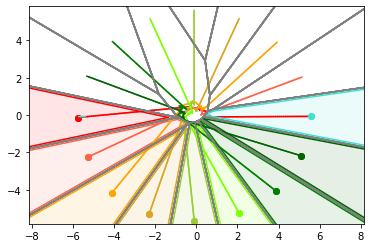

In [5]:
parameter = "robots"
print("Working on",parameter,"...")
original_value = parameters[parameter]
#parameters[parameter] = 0.2
for _ in range(95):
    print(parameter,"equal to",parameters[parameter],"...")
    main_module(parameter, 20)
    parameters[parameter] += 1
parameters[parameter] = original_value

### All Parameter Analysis

In [5]:
for parameter in parameters:
    print("Working on",parameter,"...")
    original_value = parameters[parameter]
    # To cover the range starting from the begining
    if original_value <= 0.1:
        parameters[parameter] = 0.01
    # Parameter Spectrum
    for i in range(10):
        print(parameter,"equal to",parameters[parameter],"...")
        main_module(parameter)
        if original_value >= 1:
            parameters[parameter] += 1
        elif original_value <= 0.1:
            parameters[parameter] += 0.01
    parameters[parameter] = original_value

Working on deadlock_mov ...
deadlock_mov equal to 0.01 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!


utils.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  "outputs": [


Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
deadlock_mov equal to 0.02 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
deadlock_mov equal to 0.03 ...
Experiment 0 done!
Experiment 1 done!
Experiment

### Receding Horizons Steps Analysis

In [9]:
for rh_step in range(1,20):
    print("RH steps: ",rh_step,"...")
    main_module("rh_step",rh_step)

RH steps:  1 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
RH steps:  2 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experi

KeyboardInterrupt: 

### Generate Video

In [26]:
#frameSize = (432, 288)
frameSize = (1200, 800)

out = cv2.VideoWriter('/home/leduin/Escritorio/Tesis/Imagenes/animation_simple_'
                      +str(parameters["robots"])+'.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 3, frameSize)

for filename in sorted(glob.glob('/home/leduin/Escritorio/Tesis/Imagenes/Simple/'
                                 +str(parameters["robots"])+'/*.png'),
                       key=os.path.getmtime):
    img = cv2.imread(filename)
    out.write(img)

out.release()